# YouNiverse - Navigating Collaborations in YouTube's Gaming World: A Data-Driven Journey

Team members : Lou De Bel-Air, Jiacheng Yang, Mats Hansen Frydenberg

Dataset : [YouNiverse](​​https://zenodo.org/records/4650046)

## Introduction
How are YouTube channels interconnected, and what does this connectivity indicate about their influence and reach? With the expansive 'YouNiverse' dataset as our foundation, we aim to dissect video metadata, especially descriptions, to identify mentions of other channels or explicit collaborations. However, mere mentions aren't the only indicators of influence. Viewer engagement metrics, such as views and likes, are crucial. By examining these alongside collaboration data, we can understand a channel's holistic influence. Our goal is to offer a multi-dimensional perspective on YouTube's collaborative landscape, equipping creators with insights to foster collaborations that align with evolving viewer trends.

We will explore our problem statement from the following angles: 
1. Effectiveness of Collaborations: Does collaborating with other channels lead to an increase in popularity? This involves assessing whether channels that engage in collaborations experience a significant boost in metrics like views, subscribers, and overall engagement compared to those that do not collaborate.
2. Optimal Collaboration Strategies: Which types of collaborations are most beneficial for channel growth? This includes determining whether collaborating with channels of similar popularity, are they some key channels?


In [5]:
# import statements

import collections
from collections import defaultdict
from community import community_louvain
import datetime
import math
import matplotlib.cm as cm
import matplotlib.dates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import pickle
import plotly.express as px
import plotly.graph_objs as go
import random
import re
import seaborn as sns
import scipy.stats as stats
from operator import itemgetter
import operator
import os

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [6]:
### Initial definitions and loading of datasets

# dataset file paths
data_path = './data/yt_metadata_en.jsonl.gz'
channels_path = './data/df_channels_en.tsv'
timeseries_path = './data/df_timeseries.tsv'
collaborators_path = './processed_data/dataframe_collaborations_videos.csv'
weekly_collaborators_path = './processed_data/collaborators_per_week.csv'

# Define the start and end dates of our study
start_date = pd.Timestamp('2016-01-01')
end_date = pd.Timestamp('2019-12-31')

### loading datasets and removing None 
df_channels = pd.read_csv(channels_path, sep ='\t').dropna()
df_timeseries = pd.read_csv(timeseries_path, sep ='\t').dropna()
df_collaborators = pd.read_csv(collaborators_path, sep=',').dropna()
df_weekly_collaborators = pd.read_csv(weekly_collaborators_path, sep=',')

# convert dates into datetime format
df_channels['join_date'] = pd.to_datetime(df_channels['join_date'])
df_timeseries['datetime'] = pd.to_datetime(df_timeseries['datetime'])

# only keep data within the dates of interest for our study
df_channels.drop(df_channels[df_channels.join_date > end_date].index, inplace=True)
df_timeseries.drop(df_timeseries[df_timeseries.datetime > end_date].index, inplace=True)
df_timeseries.drop(df_timeseries[df_timeseries.datetime < start_date].index, inplace=True)

# prepare channel id to channel name mapping dataset
channel_id_to_name = df_channels[['channel', 'name_cc']]

df_channels = df_channels[df_channels['category_cc']=='Gaming']
df_timeseries = df_timeseries[df_timeseries['category']=='Gaming']

# initial color setting
color = sns.color_palette("husl",9)

# Collaboration Impact Analysis

We are trying to find the impact of collaborations on a channel's popularity. In this part we will be defining the popularity of a channel by its mean number of views, as it provides a quantitative and easily interpretable measure of the channel's overall viewer engagement, capturing the average level of interest across its entire video content.

We will use the filtered dataset "dataframe_collaborations_videos" which is containing video data of the Gaming category for the 2016-2019 period, and an added column with the ids of channels identified in the videos. We will also use the "df_channels_en.tsv" dataset to find the names and number of subscribers of the channels.

First we are adding a column to the dataset to get the number of channels identified in each video. Then we create a new table containing the channel ids, their corresponding mean view count and average number of collaborations per video.

We are also using the second dataset to add a column with the number of subscribers of each channel.


In [ ]:
# Create a new column with the number of collaborators per video, put 0 if the video has no collaborators
df_collaborators['collaboration_count'] = df_collaborators['final_collaborator_ids'].apply(lambda x: 0 if pd.isna(x) else len(x.split(',')))

# Group the dataframe by channel_id and calculate the mean of view_count and final_collaborator_ids
channels_table= df_collaborators.groupby('channel_id').agg({
    'view_count': 'mean',
    'collaboration_count': 'mean'
}).reset_index()

# Rename the columns
channels_table.columns = ['channel', 'mean_view_count', 'mean_final_collaboration_count']

# Load dataset containing the number of subscribers per channel
channels_path = './data/df_channels_en.tsv.gz'
df_channels = pd.read_csv(channels_path, sep ='\t',compression='gzip')
df_channels = df_channels[['channel', 'subscribers_cc']]

# Merge the two tables
channels_table = channels_table.merge(df_channels, left_on='channel', right_on='channel', how='left')

# Sort the table by mean_view_count in descending order to have most popular channels first
channels_table.sort_values('mean_view_count', ascending=False, inplace=True)

# Display the new table
display(channels_table)


,channel,mean_view_count,mean_final_collaboration_count,subscribers_cc
12333,UCPcynnZcILjm0e2aaaTuCjw,3.821617e+08,1.666667,8470000
5539,UCAxx_o1ClhGY0PBJZ7Ge3uA,5.006198e+07,2.000000,94600
3559,UC6jvGhVm8JSCNwU1Y13BfZw,2.980671e+07,0.000000,963000
19201,UCd4iew3AeLPRSCWwu2OitEw,2.532518e+07,0.000000,1950000
15845,UCWv_20ptZMar2TDswm6wYLg,2.358715e+07,0.000000,759000
...,...,...,...,...
24330,UCnuzgY3qOvnjXumbV2vIj7w,1.138979e+01,0.000000,20000
26603,UCssVEinRlfmSxXGsvMDNHPQ,1.100000e+01,0.000000,11000
8571,UCHTnlUv7rDFz15XCO5vVi-Q,6.000000e+00,0.000000,10960
19917,UCeeC8yDOjtFl-zE0jDOKrWg,4.000000e+00,0.000000,13300


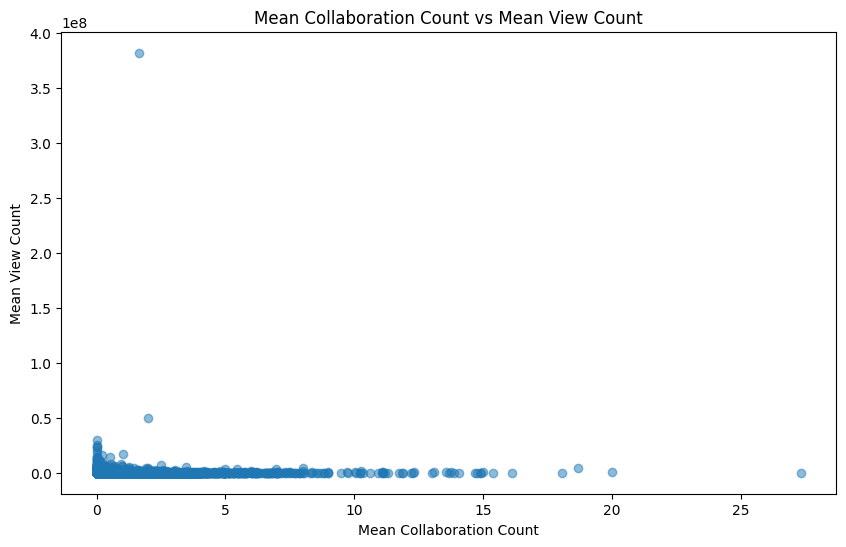

In [ ]:
# Plot mean view count vs mean collaboration count
plt.figure(figsize=(10, 6))
plt.scatter(channels_table['mean_final_collaboration_count'],channels_table['mean_view_count'], alpha=0.5)
plt.xlabel('Mean Collaboration Count')
plt.ylabel('Mean View Count')
plt.title('Mean Collaboration Count vs Mean View Count')
plt.show()

There are two problems with the above graph : all of the points are aggregated close to the origin. To remedy this problem we remove the outliers using z-score, and we use a logarithmic scale for the y-axis.

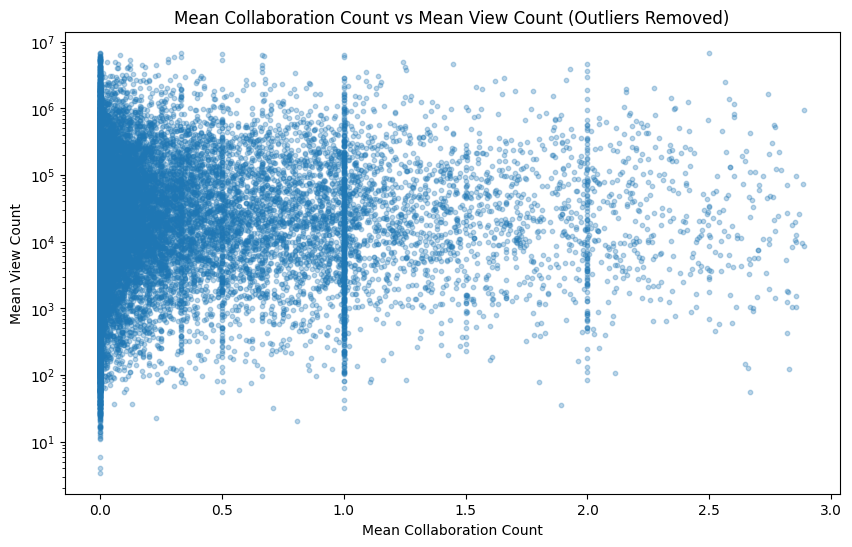

In [ ]:
# Remove outliers using z-score
z_scores = stats.zscore(channels_table[['mean_view_count', 'mean_final_collaboration_count']])
threshold = 3
channels_table_without_outliers = channels_table[(np.abs(z_scores) < threshold).all(axis=1)]


# Plot mean view count vs mean collaboration count
plt.figure(figsize=(10, 6))
plt.scatter(channels_table_without_outliers['mean_final_collaboration_count'],channels_table_without_outliers['mean_view_count'], alpha=0.3, s =10)

plt.xlabel('Mean Collaboration Count')
plt.ylabel('Mean View Count') 
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Mean Collaboration Count vs Mean View Count (Outliers Removed)')
plt.show()




We can see that most Youtubers don't do any collaborations, or only a few. A few lines appear for whole numbers of collaborations. It can be interpreted in different ways :
- Collaborations are not evenly distributed among YouTubers. Many creators may prefer to work independently or may find it logistically challenging to collaborate frequently.
- The dataset studied may not contain enough videos for each channel.

The number of collaborations does not seems to have an impact on the number of views. We are making a Welch ttest to compare the views between people that never collaborate and people who do.

In [ ]:
# Separate channels with mean_collaboration_count of 0 and others
channels_with_zero_collab = channels_table_without_outliers[channels_table_without_outliers['mean_final_collaboration_count'] == 0]
channels_with_nonzero_collab = channels_table_without_outliers[channels_table_without_outliers['mean_final_collaboration_count'] > 0]

# Perform Welch's t-test
t_stat, p_value = stats.ttest_ind(channels_with_zero_collab['mean_view_count'], channels_with_nonzero_collab['mean_view_count'], equal_var=False)

print("Mean view count for zero collab:", channels_with_zero_collab['mean_view_count'].mean())
print("Mean view count for non zero collab:", channels_with_nonzero_collab['mean_view_count'].mean())

print(p_value)
# Check if the p-value is less than 0.05 (significance level)
if p_value < 0.05:
    print("There is a significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others.")
else:
    print("There is no significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others.")


Mean view count for zero collab: 114706.62960351165
Mean view count for non zero collab: 112122.6860974477
0.5878659194080699
There is no significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others.


We find that doing collaborations don't have an impact on the popularity of channels. However, maybe collaborations don't have an impact overall but can have an impact on certain categories of Youtubers (for example non popular Youtubers). 

To discuss this, we thought of considering the number of subscribers to a channel as a measure of popularity, meaning that channels with more subscribers will tend to have more views. To avoid big Youtubers squashing the impact of collaborations on small Youtubers, we first normalized the average number of views by the number of subscribers to the channel, and repeated the same comparison as before.
Results were not concluding, and we arrived to the conclusion that subscribers are not a good popular metric. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


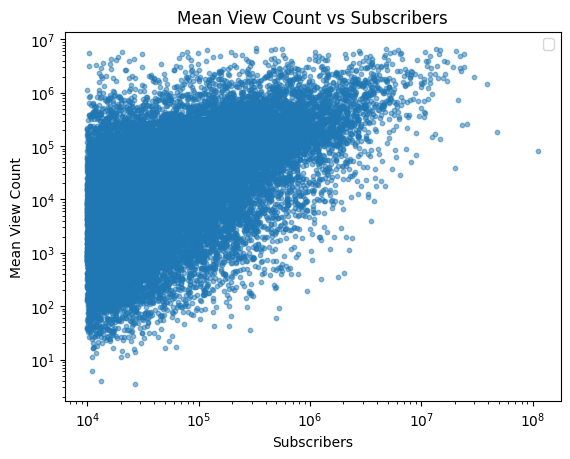

In [ ]:
plt.scatter(channels_table_without_outliers['subscribers_cc'], channels_table_without_outliers['mean_view_count'], alpha=0.5, s=10)
plt.xlabel('Subscribers')
plt.ylabel('Mean View Count')

plt.xscale('log')
plt.yscale('log')
plt.title('Mean View Count vs Subscribers')
plt.legend()

plt.show()

Indeed, when we plot the mean view count per video versus the number of subscribers we can see that there is not a direct correlation. 
Two Youtubers with the same number of subscribers (for example 10 000) can have very different number of views in their videos (either 10 or 10 000 000). 

To study the impact of collaborations on Youtubers with different popularity we will then use the mean number of views as before but separate them in 10 groups using their number of views.

Bin: (3.4330000000000003, 791.191]
Mean view count divided for channels with mean_collaboration_count of 0: 339.51422403648075
Mean view count divided for channels with mean_collaboration_count of > 0: 401.9365219023488
p-value: 1.8537374406662203e-12
len bin: 2940
There is a significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others in this bin.

Bin: (791.191, 2420.333]
Mean view count divided for channels with mean_collaboration_count of 0: 1478.3353319104779
Mean view count divided for channels with mean_collaboration_count of > 0: 1541.641782343516
p-value: 0.00027453750456465567
len bin: 2941
There is a significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others in this bin.

Bin: (2420.333, 5198.203]
Mean view count divided for channels with mean_collaboration_count of 0: 3688.7371199800905
Mean view count divided for channels with mean_collaboration_count of > 0: 3745.75

/var/folders/gx/bfgpp2gn7q9d5ddxfmsvdz080000gn/T/ipykernel_14004/1037606892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channels_table_without_outliers['mean_view_count_bin'] = pd.qcut(channels_table_without_outliers['mean_view_count'], q=10)
/var/folders/gx/bfgpp2gn7q9d5ddxfmsvdz080000gn/T/ipykernel_14004/1037606892.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_label, bin_df in channels_table_without_outliers.groupby('mean_view_count_bin'):


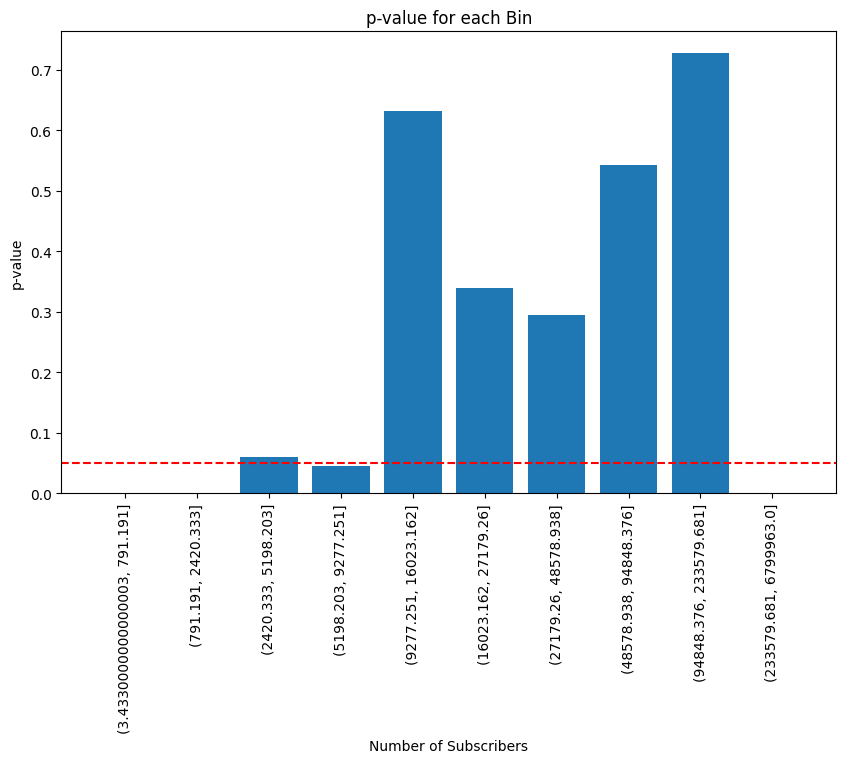

In [ ]:
# Divide merged_table_without_outliers into 10 bins based on subscribers_cc
channels_table_without_outliers['mean_view_count_bin'] = pd.qcut(channels_table_without_outliers['mean_view_count'], q=10)

# Create a list to store the p-values
p_values = []
bin_labels = []

# Perform t-test for each bin
for bin_label, bin_df in channels_table_without_outliers.groupby('mean_view_count_bin'):
    channels_with_zero_collab = bin_df[bin_df['mean_final_collaboration_count'] == 0]
    channels_with_nonzero_collab = bin_df[bin_df['mean_final_collaboration_count'] > 0]
    
    # Perform Welch's t-test
    t_stat, p_value = stats.ttest_ind(channels_with_zero_collab['mean_view_count'], channels_with_nonzero_collab['mean_view_count'], equal_var=False)
    print("Bin:", bin_label)
    print("Mean view count divided for channels with mean_collaboration_count of 0:", channels_with_zero_collab['mean_view_count'].mean())
    print("Mean view count divided for channels with mean_collaboration_count of > 0:", channels_with_nonzero_collab['mean_view_count'].mean())
    print("p-value:", p_value)
    print("len bin:", len(bin_df))
    if p_value < 0.05:
        print("There is a significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others in this bin.")
    else:
        print("There is no significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others in this bin.")
    print()
    
    # Append the p-value to the list
    p_values.append(p_value)
    bin_labels.append(str(bin_label))


# Plot the p-values
plt.figure(figsize=(10, 6))
plt.bar(bin_labels, p_values)
plt.axhline(y=0.05, color='red', linestyle='--')
plt.xlabel('Number of Subscribers')
plt.ylabel('p-value')
plt.title('p-value for each Bin')

# Rotate the x-axis labels
plt.xticks(rotation='vertical')

plt.show()


Even if overall collaborations does not have an impact on the popularity of a Youtuber we can see that it is not true for all bins. While for most collaborations don't have an impact, for small Youtubers (that don't make a lot of views) this result is not true anymore. For those who have less than 2420.333 views in average the ttest suggests that Youtubers that collaborate will tend to have more views than those who don't.

Another result is that for really big Youtubers, collaborations also have an impact but a negative one. 

In [ ]:
channels_table_without_outliers.sort_values('mean_view_count', ascending=False, inplace=True)
display(channels_table_without_outliers)

/var/folders/gx/bfgpp2gn7q9d5ddxfmsvdz080000gn/T/ipykernel_14004/62609457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_table_without_outliers.sort_values('mean_view_count', ascending=False, inplace=True)


,channel_id,mean_view_count,mean_final_collaboration_count,mean_view_count_bin
25741,UCqxgIQs2EwEuAppj4B2vVLA,6.799963e+06,2.500000,"(233579.681, 6799963.0]"
29770,UCz_yk8mDSAnxJq0ar66L4sw,6.675913e+06,0.000000,"(233579.681, 6799963.0]"
7563,UCFMOW7zjCVT7k3va5bHSYqg,6.665669e+06,0.333333,"(233579.681, 6799963.0]"
22519,UCkDbxGSyvOgR8UJj3m0GC6Q,6.664194e+06,0.000000,"(233579.681, 6799963.0]"
13053,UCR4s1DE9J4DHzZYXMltSMAg,6.529849e+06,0.000000,"(233579.681, 6799963.0]"
...,...,...,...,...
24330,UCnuzgY3qOvnjXumbV2vIj7w,1.138979e+01,0.000000,"(3.4330000000000003, 791.191]"
26603,UCssVEinRlfmSxXGsvMDNHPQ,1.100000e+01,0.000000,"(3.4330000000000003, 791.191]"
8571,UCHTnlUv7rDFz15XCO5vVi-Q,6.000000e+00,0.000000,"(3.4330000000000003, 791.191]"
19917,UCeeC8yDOjtFl-zE0jDOKrWg,4.000000e+00,0.000000,"(3.4330000000000003, 791.191]"


Now we will proceed to answer the following research question: 
 
**2. How are YouTube channels interconnected, and what does this connectivity indicate about their influence and reach?**

**Network Analysis within Gaming Category:**

We plan to identify key influencers and collaboration patterns in the Gaming category. The objective is to construct a network graph representing channels as nodes and collaborations as edges.
Then we will determine centrality measures to identify influential channels and analyze the frequency and scope of collaborations. To identify influential nodes and sub-networks in the games category we can use graph-theoretic measures (Louvain Community Detection). Visualization can be done through the application of NetworkX.

Sources: 
- https://memgraph.com/blog/community-detection-algorithms-with-python-networkx
- https://towardsdatascience.com/community-detection-algorithms-9bd8951e7dae


We have saved something as a pickle, so that we do not need to compute it everytime, this is parts that takes a lot of time. 
That is why they are commented out, but it is just to show the code. In addition, ploting the network-graph takes time.  

**From milestone 2** We have 18.73 percent of rows where the collaborator ID is not NaN. This means that 18.73% of the videos that is published within the period has a collaborator within. We will now go into detail on the network of these collaborators. 


First part of notebook, we need to clean collaborators_per_week from Milestone 2, to get the a dataframe to make a network graph out of. 

In [ ]:
#Remove all with a Nan in collaborators, so cut out the weeks where a channel did not have a collaborator
df_collab_per_week_nonNAN = weekly_collaborators_path.dropna(subset=['collaborators_in_week'])

# Step 1: Data Cleaning and Transformation
def clean_and_extract_ids(row):
    # Implement the cleaning and extraction logic here
    # Return a list of channel IDs
    list_channel_ids = []
    try:
        cleaned_row = row.replace("[", "").replace("]", "").replace("'", "").replace("\n", " ").replace("None", "")
        ids = cleaned_row.split()  # This splits the string on spaces
        for id in ids:
            list_channel_ids.append(id)
    except Exception as e:
        print(f"Error processing row: {row}. Error: {e}")
    return list_channel_ids


# Apply the function to each row and create a new column for extracted IDs
df_collab_per_week_nonNAN['extracted_collaborators'] = df_collab_per_week_nonNAN['collaborators_in_week'].apply(clean_and_extract_ids)

display(df_collab_per_week_nonNAN)


,Year-Week,channel_id,collaborators_in_week,extracted_collaborators
1,2016-00,UC-1pADhAUignVbTbVCW4Uuw,['UChm3iPolG6IVrIQ3bc6bIuQ' 'UCYFn32jjeY0Rx6jx...,"[UChm3iPolG6IVrIQ3bc6bIuQ, UCYFn32jjeY0Rx6jxd_..."
4,2016-00,UC-46hTnlyW3aCwjHs2acDzg,[None 'ARLNoble' 'xMattyG1' 'tiametmarduk1'],"[ARLNoble, xMattyG1, tiametmarduk1]"
7,2016-00,UC-AVK_NtJg6aSYAeEbYnfIw,theDarkElfX,[theDarkElfX]
8,2016-00,UC-BG8jc9gI_BpobNXldQuFw,['morachi24' 'BSquaredHD'],"[morachi24, BSquaredHD]"
18,2016-00,UC-WA0qTCwuMCd418q_6xbEg,krypto9095,[krypto9095]
...,...,...,...,...
1872846,2019-42,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]
1872847,2019-43,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]
1872848,2019-44,UCRIxiOJN0Xd3evqxRu4iXew,['albertsunzheng' 'MrCasping'],"[albertsunzheng, MrCasping]"
1872849,2019-44,UCoaHAPh8BecD4qjwmuE96aw,UC0p1OMeCD9OPNmIWCfqdJ7w,[UC0p1OMeCD9OPNmIWCfqdJ7w]


In [ ]:
#Rest index
df_collab_per_week_nonNAN_index_reset = df_collab_per_week_nonNAN.reset_index()

#We saw that some people listed the same channels 150 times, in the same week, this gives a unreal distribution of our network
#If he not made that much videos in that week. 
#Example
print(df_collab_per_week_nonNAN_index_reset.iloc[1854].loc['extracted_collaborators'][:30])


def remove_duplicates(collab_list):
    """
    Return a list with only unique items.
    """
    return list(set(collab_list))


# Apply the function to the 'extracted_collaborators' column
df_collab_per_week_nonNAN_index_reset['unique_collaborators'] = df_collab_per_week_nonNAN_index_reset['extracted_collaborators'].apply(remove_duplicates)


display(df_collab_per_week_nonNAN_index_reset[df_collab_per_week_nonNAN_index_reset['channel_id']=='UCgc8PshAGngxCLCMfoy8NpQ'])

['PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile', 'PlayscopeHD', 'PlayscopeTimeline', 'playscopemobile']


,index,Year-Week,channel_id,collaborators_in_week,extracted_collaborators,unique_collaborators
1854,6752,2016-01,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[playscopemobile, PlayscopeHD, PlayscopeTimeline]"
3594,12880,2016-02,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[playscopemobile, PlayscopeHD, PlayscopeTimeline]"
5388,19138,2016-03,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[playscopemobile, PlayscopeHD, PlayscopeTimeline]"
7199,25472,2016-04,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[playscopemobile, PlayscopeHD, PlayscopeTimeline]"
9031,31841,2016-05,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeHD' 'PlayscopeTimeline' 'playscopem...,"[PlayscopeHD, PlayscopeTimeline, playscopemobi...","[playscopemobile, PlayscopeHD, PlayscopeTimeline]"
...,...,...,...,...,...,...
459852,1829452,2019-35,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]
462317,1840028,2019-36,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]
464771,1850573,2019-37,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]
467230,1861124,2019-38,UCgc8PshAGngxCLCMfoy8NpQ,['PlayscopeTrailers' 'PlayscopeTrailers' 'Play...,"[PlayscopeTrailers, PlayscopeTrailers, Playsco...",[PlayscopeTrailers]


In [ ]:
#Find channels with most unique collaborations: 
df_collab_per_week_nonNAN_index_reset['num_collaborators'] = df_collab_per_week_nonNAN_index_reset['unique_collaborators'].apply(len)
# Group by 'channel_id' and sum the 'num_collaborators' for each unique channel
aggregated_collaborators_df = df_collab_per_week_nonNAN_index_reset.groupby('channel_id')['num_collaborators'].sum().reset_index()

# Rename the summed column to 'total_collaborators'
aggregated_collaborators_df.rename(columns={'num_collaborators': 'total_collaborators'}, inplace=True)
aggregated_collaborators_df.sort_values(by = 'total_collaborators',ascending=False).head(10)

,channel_id,total_collaborators
3556,UCBw-Dz6wHRkxiXKCLoWqDzA,13291
5504,UCIciwR-CmXsaunrGw2DBjhA,5904
17519,UCxTjqtGRSkfhfnLp52ggcrA,4209
14892,UCo5fwkuD4XQi33vIpbi886w,3230
13289,UCimN5mkyHUmO3oQsU7c4uYQ,2687
5158,UCHSI8erNrN6hs3sUK6oONLA,2632
2031,UC6LYaCnVf9l-kIuVg2pPTHg,2433
17030,UCvaCEaGOHviqTIxzYKpcSLg,2394
1004,UC2_LJGtXaD9B8hsmXLj4IRw,2243
18254,UCzz9_nzdbrxnErTZPZdZ-cw,2215


count    18259.000000
mean        64.209376
std        193.155513
min          1.000000
25%          3.000000
50%         12.000000
75%         53.000000
max      13291.000000
Name: total_collaborators, dtype: float64


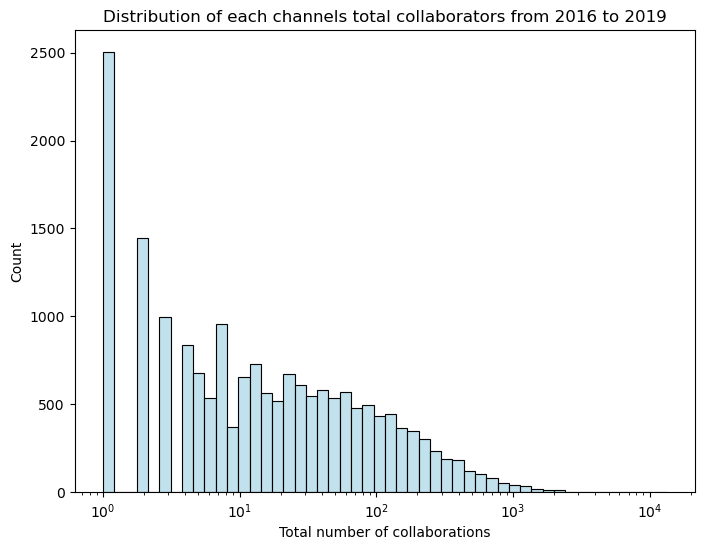

In [ ]:
#The distribution of collaborators: 
print(aggregated_collaborators_df['total_collaborators'].describe())

# Histogram with adjusted bins and log scale
plt.figure(figsize=(8, 6))
sns.histplot(aggregated_collaborators_df, x="total_collaborators", bins=50, color='lightblue',log_scale=True')
plt.xlabel('Total number of collaborations')
plt.title('Distribution of each channels total collaborators from 2016 to 2019')
plt.savefig('Total_collaborators.png')
plt.show()

**Making the network** 
1) Make the edge list 
2) Assigne a network, but our edgelist is so big so we need to bootstrap the edge list to create a graph plot.   

In [ ]:
# Helper function from ADA excersice 11: 

def plot_log_log_degree_distribution(G):
    # Collect all degrees in the graph
    all_degrees = [G.degree(node) for node in G.nodes() if G.degree(node) > 0]  # Exclude zero-degree nodes

    # Define the number of bins
    num_bins = 50  # You can adjust this number as needed

    # Create logarithmically spaced bins
    log_bins = np.logspace(np.log10(min(all_degrees)), np.log10(max(all_degrees)), num=num_bins)

    # Plot the histogram
    fig, ax = plt.subplots()
    sns.histplot(all_degrees, bins=log_bins, edgecolor='black',color='lightblue')
    plt.title("Degree Distribution (Log-Log scale)")
    plt.ylabel("Frequency")
    plt.xlabel("Number of collaborators")
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

# Helper function for printing various graph properties
def describe_graph(G):
    print(G)
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

In [ ]:
with open('edges_pickle.pkl', 'rb') as f:
    edges = pickle.load(f)

print(edges[:10])

[('UC-1pADhAUignVbTbVCW4Uuw', 'UCj8pJC0ONCz5zClAewsbSOw'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UChm3iPolG6IVrIQ3bc6bIuQ'), ('UC-1pADhAUignVbTbVCW4Uuw', 'UCYFn32jjeY0Rx6jxd_b_QQA'), ('UC-46hTnlyW3aCwjHs2acDzg', 'ARLNoble'), ('UC-46hTnlyW3aCwjHs2acDzg', 'tiametmarduk1'), ('UC-46hTnlyW3aCwjHs2acDzg', 'xMattyG1'), ('UC-AVK_NtJg6aSYAeEbYnfIw', 'theDarkElfX'), ('UC-BG8jc9gI_BpobNXldQuFw', 'morachi24'), ('UC-BG8jc9gI_BpobNXldQuFw', 'BSquaredHD'), ('UC-WA0qTCwuMCd418q_6xbEg', 'krypto9095')]


In [ ]:
with open('your_networkx_graph.pkl', 'rb') as f:
    G = pickle.load(f)
describe_graph(G)


Graph with 201936 nodes and 297276 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0000
Global clustering coefficient aka Transitivity: 0.0021


In [ ]:
#This takes a lot of time: 
print(f"Average degree in overall Graph: {sum(dict(G.degree()).values()) / float(G.number_of_nodes()):.4f}")

sorted_nodes_by_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)

print("First stats about total connections:")
# Top 10 nodes with the most connections
top_10_nodes = sorted_nodes_by_degree[:10]
for node, degree in top_10_nodes:
    print(f"Node {node} has {degree} connections")

Average degree in overall Graph: 2.9443
First stats about total connections:
Node UCBw-Dz6wHRkxiXKCLoWqDzA has 11422 connections
Node UCIciwR-CmXsaunrGw2DBjhA has 3351 connections
Node UCxTjqtGRSkfhfnLp52ggcrA has 2838 connections
Node UCN-v-Xn9S7oYk0X2v1jx1Qg has 1779 connections
Node UCWVuy4NPohItH9-Gr7e8wqw has 1702 connections
Node UCvaCEaGOHviqTIxzYKpcSLg has 1676 connections
Node UC6LYaCnVf9l-kIuVg2pPTHg has 1592 connections
Node UCo5fwkuD4XQi33vIpbi886w has 1525 connections
Node UC2_LJGtXaD9B8hsmXLj4IRw has 1237 connections
Node UCv5gQgP_uGbJxImWVoUC_Ng has 1145 connections


In [ ]:
def bootstrap_edges(edges, n_bootstrap, sample_size):
    """
    Generate n_bootstrap bootstrapped samples of the edge list.
    """
    bootstrapped_samples = []
    for _ in range(n_bootstrap):
        sampled_edges = [random.choice(edges) for _ in range(sample_size)]
        bootstrapped_samples.append(sampled_edges)
    return bootstrapped_samples


bootstrapped_edge_lists = bootstrap_edges(edges, n_bootstrap=50, sample_size=10000)

In [ ]:
# Create a dictionary to count the occurrence of each edge across all bootstrapped samples
edge_frequency = defaultdict(int)

for bootstrapped_edges in bootstrapped_edge_lists:
    for edge in bootstrapped_edges:
        # Sort the tuple to avoid duplicate edges in different orders
        sorted_edge = tuple(sorted(edge))
        edge_frequency[sorted_edge] += 1

# Convert counts to probabilities
total_samples = len(bootstrapped_edge_lists)
edge_probability = {edge: count/total_samples for edge, count in edge_frequency.items()}

# Set a threshold for including an edge
threshold = 0.2  

# Create a new edge list that includes edges meeting the threshold
representative_edges = [edge for edge, probability in edge_probability.items() if probability >= threshold]

G_bootstrapped = nx.Graph()
G_bootstrapped.add_edges_from(representative_edges)


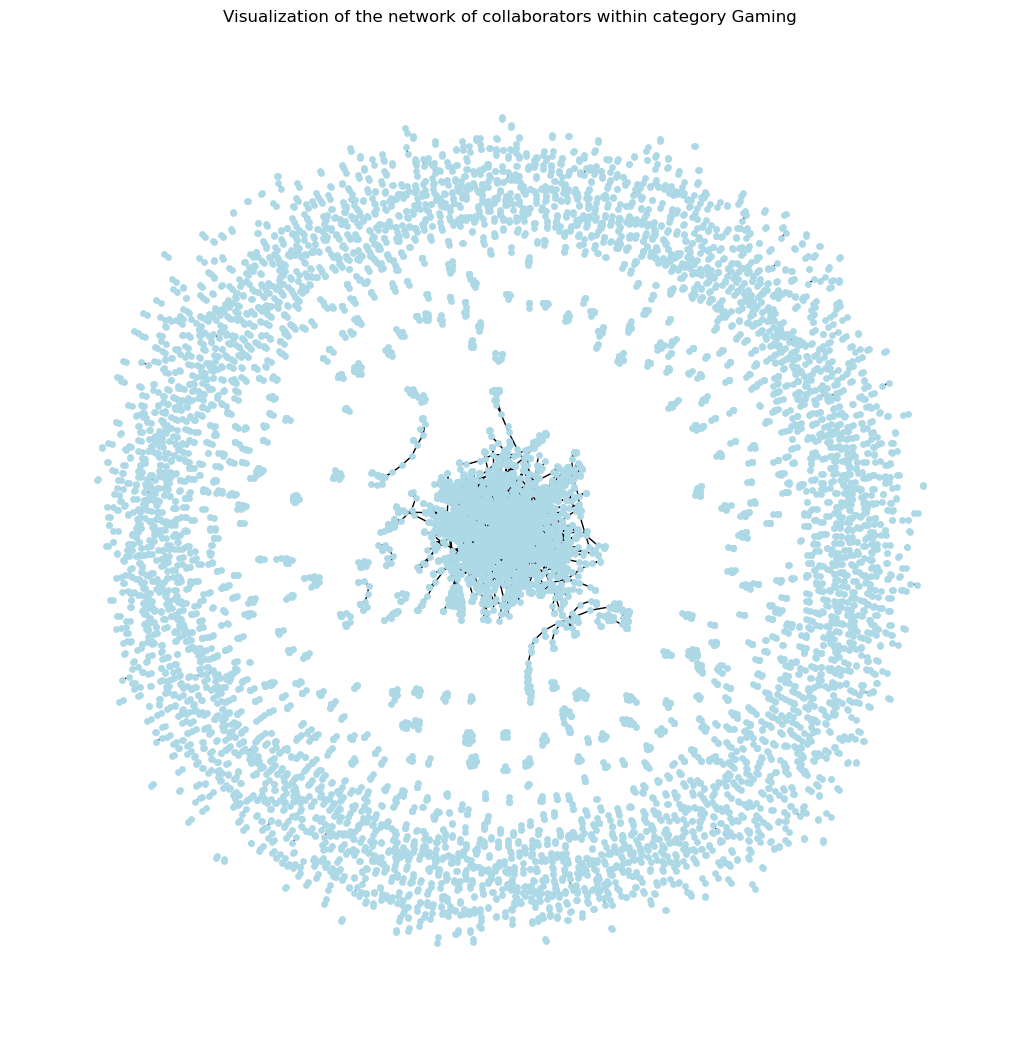

In [ ]:
G_bootstrapped = nx.Graph()
G_bootstrapped.add_edges_from(representative_edges)

plt.figure(figsize=(10, 10))
nx.draw(G_bootstrapped, node_size=15, edge_color="black", node_color='lightblue',with_labels=False)
plt.title("Visualization of the network of collaborators within category Gaming")
plt.savefig("Bootstrapped_network.png")
plt.show()

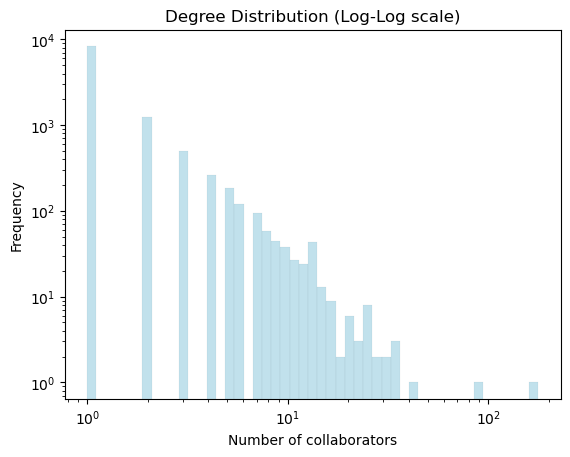

<Figure size 640x480 with 0 Axes>

In [ ]:
degree_distribution = plot_log_log_degree_distribution(G_bootstrapped)
plt.savefig('degree_distribtuion.png')

**Decsribing the network**

We then move on to decsribing the network, with methodes learned in class. 

In [ ]:
#From https://github.com/epfl-ada/2023/tree/main/Exercises/10%20-%20Handling%20networks
#G_bootstrapped
print("Network sparsity: %.4f" %nx.density(G_bootstrapped))
print(nx.is_connected(G_bootstrapped))
comp = list(nx.connected_components(G_bootstrapped))
print('The graph contains', len(comp), 'connected components')
largest_comp_b = max(comp, key=len)
percentage_lcc_b = len(largest_comp_b)/G_bootstrapped.number_of_nodes() * 100
print('The largest component has', len(largest_comp_b), 'nodes', 'accounting for %.2f'% percentage_lcc_b, '% of the nodes') 
print('%.4f' %nx.transitivity(G_bootstrapped))

Network sparsity: 0.0002
False
The graph contains 2577 connected components
The largest component has 2964 nodes accounting for 26.93 % of the nodes
0.0383


In [ ]:
#From https://github.com/epfl-ada/2023/tree/main/Exercises/10%20-%20Handling%20networks
degrees = dict(G_bootstrapped.degree(G_bootstrapped.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for channel, degree in sorted_degree[:5]:
    print(channel, 'who is connected to', degree, 'channels')

NoCopyrightSounds who is connected to 177 channels
CHUKImusic who is connected to 93 channels
UC_aEa8K-EOJ3D6gOs7HcyNg who is connected to 44 channels
UCeE4VazTtIl502GDwUndZCQ who is connected to 33 channels
UCHSI8erNrN6hs3sUK6oONLA who is connected to 33 channels


In [ ]:
#open bootstrapped: 
with open('betweenness_centrality_b.pkl', 'rb') as f:
    betweenness_b = pickle.load(f)

sorted_betweenness_b = sorted(betweenness_b.items(), key=itemgetter(1), reverse=True)

for channel, bw in sorted_betweenness_b[:5]:
    print(f"{channel}, who has betweenness: {bw:.3f}")

NoCopyrightSounds, who has betweenness: 0.036
CHUKImusic, who has betweenness: 0.012
UC-nL_2TP09QuovUwqg6CUOQ, who has betweenness: 0.009
UC_aEa8K-EOJ3D6gOs7HcyNg, who has betweenness: 0.009
Cheridet, who has betweenness: 0.008


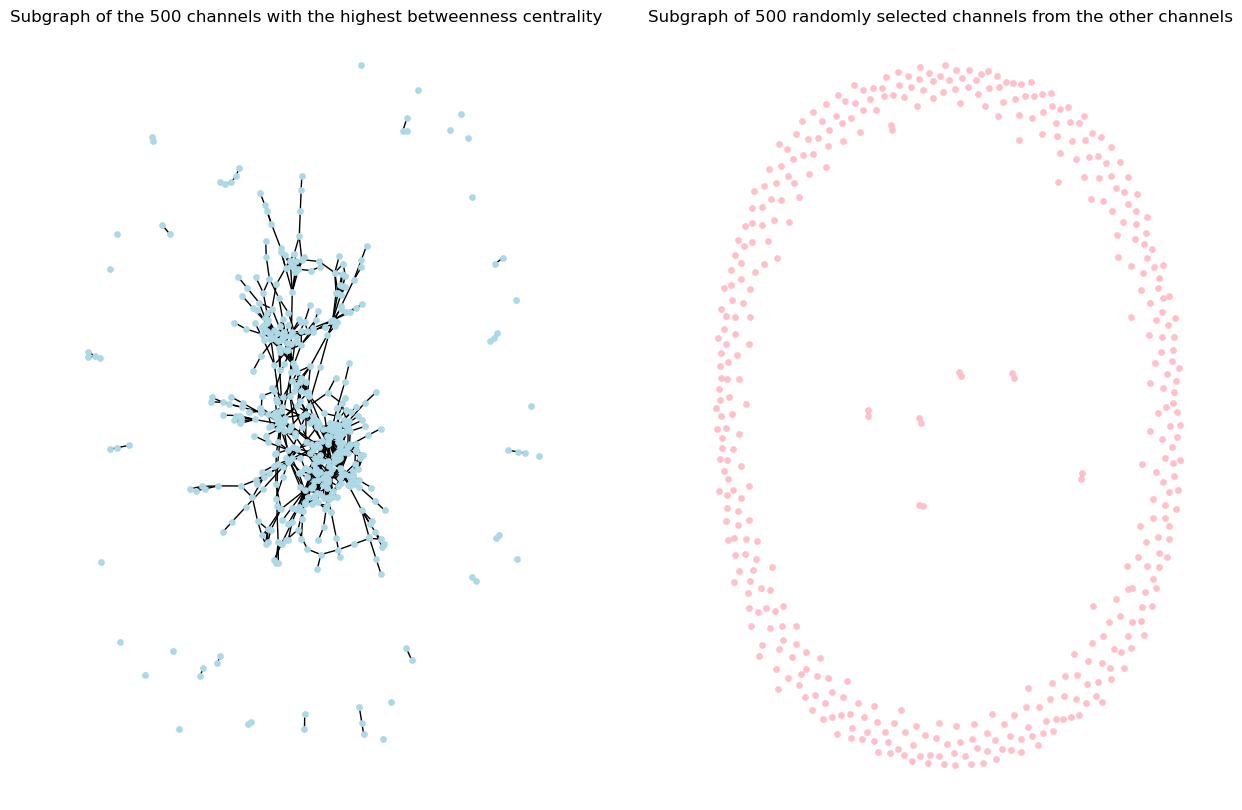

In [ ]:
sorted_nodes_by_degree = sorted(betweenness_b.items(), key=operator.itemgetter(1), reverse=True)

# Sort nodes by their betweenness centrality and get the top 500
top_betweenness_nodes = sorted_nodes_by_degree[:500]
top_betweenness_nodes = [node for node, _ in top_betweenness_nodes]

# Create a subgraph with these top nodes
subgraph_betweenness = G_bootstrapped.subgraph(top_betweenness_nodes)

#Do the same for the rest of the nodes
rest_of_the_nodes = [node for node, _ in sorted_nodes_by_degree[500:]]
rest_of_the_nodes_random = random.sample(rest_of_the_nodes, 500)

# Create a subgraph with the random nodes
subgraph_random = G_bootstrapped.subgraph(rest_of_the_nodes_random)

# Visualize the subgraphs as a two subplot
plt.figure(figsize=(15, 10))

# Left plot - Top 500 nodes by betweenness centrality
plt.subplot(1, 2, 1)
nx.draw(subgraph_betweenness, node_size=15, with_labels=None, node_color='lightblue', edge_color='black')
plt.title("Subgraph of the 500 channels with the highest betweenness centrality")

# Right plot - Random 10 nodes from the rest
plt.subplot(1, 2, 2)
nx.draw(subgraph_random, node_size=15, with_labels=None, node_color='pink', edge_color='black')
plt.title("Subgraph of 500 randomly selected channels from the other channels")
plt.savefig('Showing_network.png')
plt.show()

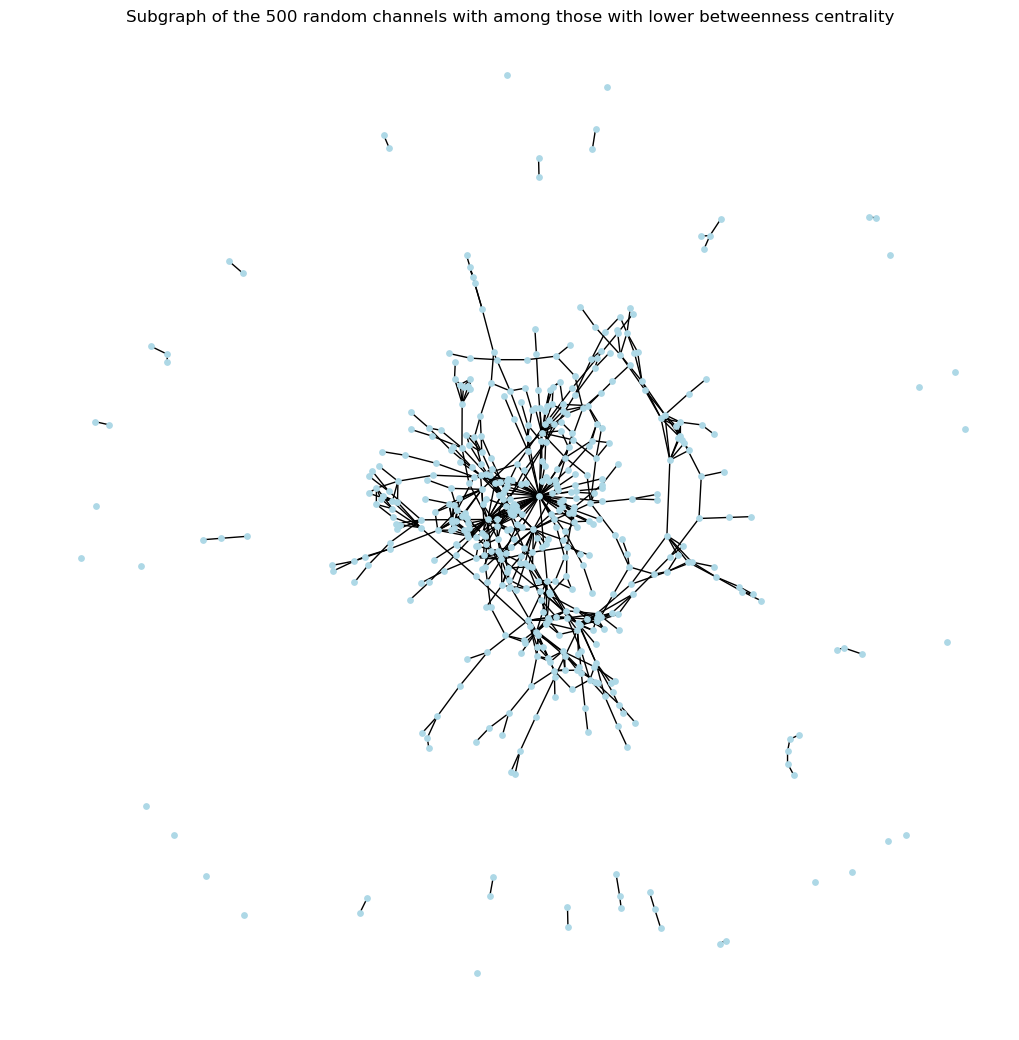

In [ ]:
# Sort nodes by their betweenness centrality and get the top 500
top_betweenness_nodes = sorted(betweenness_b.items(), key=operator.itemgetter(1), reverse=True)[:500]
top_betweenness_nodes = [node for node, _ in top_betweenness_nodes]

# Create a subgraph with these top nodes
subgraph_betweenness = G_bootstrapped.subgraph(top_betweenness_nodes)

# Visualize the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph_betweenness, node_size = 15, with_labels=None, node_color='lightblue', edge_color='black')
plt.title("Subgraph of the 500 random channels with among those with lower betweenness centrality")
plt.savefig("")
plt.show()

In [ ]:
#closness centrality: 
G_bootstrapped_closness = nx.closeness_centrality(G_bootstrapped)

G_bootstrapped_closness = sorted(G_bootstrapped_closness.items(), key=lambda item: item[1], reverse=True)

In [ ]:
# Extract just the nodes for the top 100

top_500_nodes = [node for node, degree in sorted_nodes_by_degree[:500]]
subgraph_top_500 = G.subgraph(top_500_nodes)

In [ ]:
#Describe 500
print("Network sparsity: %.4f" %nx.density(subgraph_top_500))
print(nx.is_connected(subgraph_top_500))
comp = list(nx.connected_components(subgraph_top_500))
print('The graph contains', len(comp), 'connected components')
largest_comp_b = max(comp, key=len)
percentage_lcc_b = len(largest_comp_b)/subgraph_top_500.number_of_nodes() * 100
print('The largest component has', len(largest_comp_b), 'nodes', 'accounting for %.2f'% percentage_lcc_b, '% of the nodes') 
print('%.4f' %nx.transitivity(subgraph_top_500))

Network sparsity: 0.0091
False
The graph contains 116 connected components
The largest component has 370 nodes accounting for 74.00 % of the nodes
0.1666


In [ ]:

partition = community_louvain.best_partition(subgraph_top_500)
# add it as an attribute to the nodes
for n in subgraph_top_500.nodes:
    subgraph_top_500.nodes[n]["louvain"] = partition[n]


In [ ]:
#link: https://plotly.com/python/network-graphs/
# Calculate layout for our nodes 
pos = nx.spring_layout(subgraph_top_500, k=0.2)

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in subgraph_top_500.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += (x0, x1, None)
    edge_trace['y'] += (y0, y1, None)

# Create node trace
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,  # Set showscale to False to hide the colorbar
        colorscale='Jet',
        color=[subgraph_top_500.nodes[node]["louvain"] for node in subgraph_top_500.nodes],
        size=10,
        line_width=2))

# Add node positions to the node trace
for node in subgraph_top_500.nodes():
    x, y = pos[node]
    node_trace['x'] += (x,)
    node_trace['y'] += (y,)
    node_info = f"# of Collaborators: {subgraph_top_500.degree(node)}"
    node_trace['text'] += (node_info,)

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph of the 500 channels with most collaborators',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[{
                    "text": "Hover to see the number of collaborators",
                    "showarrow": False,
                    "xref": "paper",
                    "yref": "paper",
                    "x": 0.005,
                    "y": -0.002 
                }],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

# Show the figure
fig.show()

fig.write_html('Total_collaborators.html')


**Finding how they are collaborating with**

1) Load dataframes, to find the ones outside gaming
2) Need to work on the dateframe 

In [ ]:
# Group by 'channel_id' and sum the 'view_count'
agg_df = df_collaborators.groupby('channel_id')['view_count'].sum().reset_index()

# Rename columns for clarity
agg_df.columns = ['channel_id', 'total_views']

# Now agg_df is your desired DataFrame
display(agg_df.head(10))
display(agg_df[agg_df['channel_id']=='FlockOfNerdsdotCom'])

,channel_id,total_views
0,UC--7oyGW0N7fMf164-ZXljQ,1375099.0
1,UC--b720KocplK9zh0peruqg,943339.0
2,UC--oOv_2PpzwK4WNsjG2UAw,2891.0
3,UC--szL7ECbL2jmnOpx6BrNg,2161.0
4,UC--vL4ZYLa0bi3TQcuwrhoA,8044163.0
5,UC-05oNebNywp5jy7iXZWZzA,985856.0
6,UC-07j8SBVA5mHbiNWe2-jcw,23055.0
7,UC-0Wg1wOUp-bRF1ZiC0dE8g,10536233.0
8,UC-0xJTkutOCoRoBi3YOkHRg,5445631.0
9,UC-10uJUkzxSXa9sEtV67YcA,10137899.0


,channel_id,total_views


What we see is that a lot of the collaboarations happens with people that are not within the gaming category. 
From the edges list, check how has a channel_id within the df_collab_videos[channel_id] column, if not make me a list of the ones that are within and the ones that are outside. 

In [ ]:
# Extract unique channel IDs from edges
unique_channels_in_edges = set([channel for edge in edges for channel in edge])

# Channels within the gaming category
channels_within = set(df_collaborators['channel_id'])

# Determine channels in edges that are within and outside the gaming category
channels_within_category = unique_channels_in_edges.intersection(channels_within)
channels_outside_category = unique_channels_in_edges.difference(channels_within)

# Convert sets to lists (optional, depending on your further use)
channels_within_category_list = list(channels_within_category)
channels_outside_category_list = list(channels_outside_category)


In [ ]:
#Use raw to find the views for the channels: "./data/_raw_df_timeseries.tsv.gz"
# Create a set of channel IDs from the DataFrame

channels_in_df = set(df_collaborators['channel_id'])

# New edges list with both channel IDs in the DataFrame
new_edges_within = [(ch1, ch2) for ch1, ch2 in edges if ch1 in channels_in_df and ch2 in channels_in_df]

# Edges list with at least one channel ID outside the DataFrame
edges_outside = [(ch1, ch2) for ch1, ch2 in edges if ch1 not in channels_in_df or ch2 not in channels_in_df]

The following plots was done with help of https://plotly.com/python/network-graphs/ and OPENAI - CHATGPT 4

In [ ]:
num_edges_within = len(new_edges_within)
num_edges_outside = len(edges_outside)

# Data to plot
labels = ['Collaborations Within', 'Collaborations Outside']
values = [num_edges_within, num_edges_outside]
colors = ['lightblue', 'lightgreen']

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.3)])

# Customize the layout and colors
fig.update_traces(marker=dict(colors=colors), textinfo='percent+label')
fig.update_layout(
    title_text='Proportion of Collaborations Within vs Outside the Original DataFrame',
    annotations=[dict(text='Collaborations', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

# Show the figure
fig.show()

# Save the plot to an HTML file (optional)
fig.write_html('Collaborations_Proportion.html')

Graph with 2846 nodes and 2164 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0005
Global clustering coefficient aka Transitivity: 0.1638


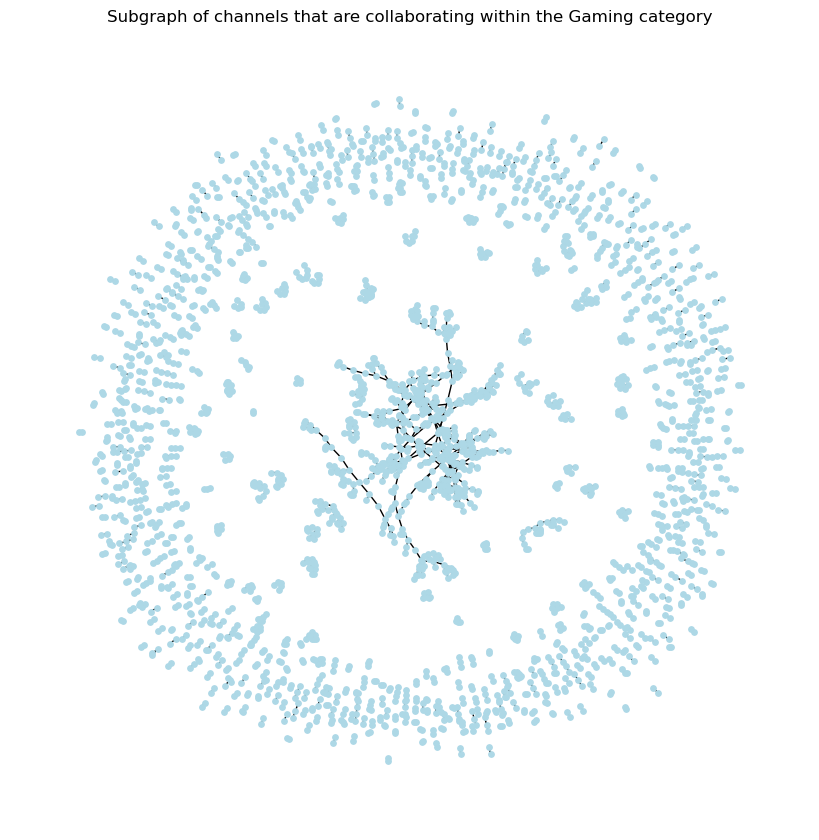

In [ ]:
new_edges_within_random = random.sample(new_edges_within, 3000)

G_within = nx.Graph()
G_within.add_edges_from(new_edges_within_random)


describe_graph(G_within)

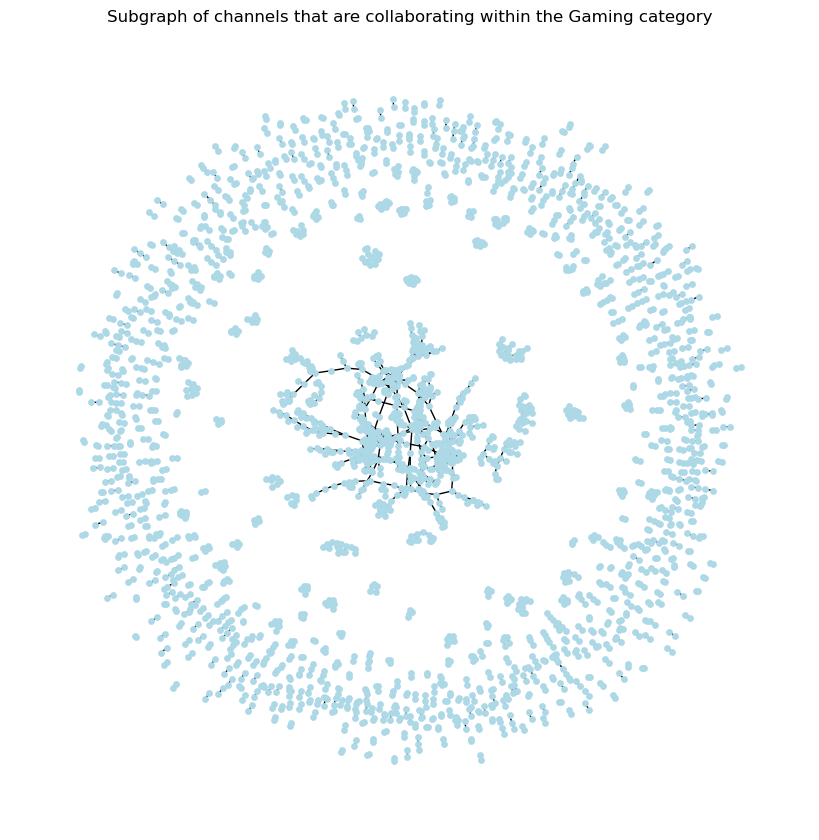

In [ ]:
# plot it out
# Visualize the subgraph
plt.figure(figsize=(8, 8))
nx.draw(G_within, with_labels=None, node_size=15, node_color = 'lightblue',edge_color='black')
plt.title("Subgraph of channels that are collaborating within the Gaming category")
plt.tight_layout()
plt.savefig("collaboration_withing_gaming_.png")
plt.show()

In [ ]:
_raw_channels_path = "./data/_raw_df_channels.tsv/df_channels.tsv"

# Define the start and end dates of our study
start_date = pd.Timestamp('2016-01-01')
end_date = pd.Timestamp('2019-12-31')

### loading datasets
df_channels_raw = pd.read_csv(_raw_channels_path, sep ='\t')

# convert dates into datetime format
df_channels_raw['join_date'] = pd.to_datetime(df_channels_raw['join_date'])

# only keep data within the dates of interest for our study
df_channels_raw.drop(df_channels_raw[df_channels_raw.join_date > end_date].index, inplace=True)

display(df_channels_raw)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb
0,Film and Animation,2017-05-21,UCBJuEqXfXTdcPSbGO9qqn1g,MagnusNation,65100,28,231223.0
1,Entertainment,2011-12-13,UCkNW9Q1VR_aeZ6uht83jJVQ,Mago Dario Animazion...,60200,48,238538.0
2,Music,2008-03-17,UCXhkGgooXHDNwgJXmoTSN7g,Mago Merlino,14800,838,707828.0
3,Entertainment,2014-10-19,UCvZGsuvKlYOGiZTsxwJNS5Q,MAGO TOMÁS,26200,31,424550.0
4,Comedy,2017-01-15,UCxJWPpPED-J24znoKyKZYjg,Magog of Morskar,29400,158,422966.0
...,...,...,...,...,...,...,...
156972,Gaming,2008-08-18,UCEqenmVLMGDN5yvbEQeaC7w,Elajjaz,97200,432,165917.0
156973,Autos & Vehicles,2006-05-09,UC-RZIjGh-BMEfzY1gb3XCCg,ElaKiri,154000,72,101165.0
156974,Gaming,2017-07-02,UCcU43L4KBWYqMP5suA3DUDA,ElAlejo,11400,17,NaN
156975,Music,2015-09-26,UCEU5ZK7DwN9ppqPFJiGah3A,ElAlfaElJefeTV,2720000,84,NaN


In [ ]:
#To do analysis if their is a difference between the ones with highest degree and the rest, we need to modify the dataframes. It is done in the next four following cells. 
# Group by 'channel_id' and sum the 'view_count'
agg_df_2 = df_channels_raw.groupby('channel')['subscribers_cc'].sum().reset_index()
agg_df_2['name_cc'] = df_channels_raw['name_cc']
agg_df_2['category_cc'] = df_channels_raw['category_cc']

agg_df_2_gaming = agg_df_2[agg_df_2['category_cc'].isin(['Gaming'])]
agg_df_2.columns = ['channel_id', 'subscribers_cc','name_cc','category_cc']
 

In [ ]:
# Randomly sample 10 from the top 100
top_50_nodes = [node for node, degree in sorted_nodes_by_degree[:50]]
random_10_from_top_50 = random.sample(top_50_nodes, 10)

# Get the rest of the nodes (all nodes except the top 100, but not to small, since then they are not visible in the dataset)
rest_of_the_nodes = [node for node, degree in sorted_nodes_by_degree[100:10000]]

# Randomly sample 10 from the rest of the nodes
random_10_from_rest = random.sample(rest_of_the_nodes, 10)


In [ ]:
#The rest are usually real channels, but we need to have a higher treshhold, since these channels are to low. 

top_df = agg_df_2[(agg_df_2['channel_id'].isin(random_10_from_top_50)) | (agg_df_2['name_cc'].isin(random_10_from_top_50))]
top_df['Group'] = 'Top'

# Create a DataFrame for the rest of the channels
# Check if the channel_id or name is in rest_channels
rest_df = agg_df_2[(agg_df_2['channel_id'].isin(random_10_from_rest)) | (agg_df_2['name_cc'].isin(random_10_from_rest))]
rest_df['Group'] = 'Rest'

# Combine the two DataFrames
combined_df = pd.concat([top_df, rest_df])

#Remove dublicate if double
combined_df = combined_df.drop_duplicates(subset='channel_id', keep='first')


In [ ]:
#Update the combined

betweenness_dict = dict(sorted_betweenness_b)
sorted_nodes_by_degree_dict = dict(sorted_nodes_by_degree)
# Map the betweenness centrality scores from betweenness_dict to the DataFrame
combined_df['betweenness_score'] = combined_df['channel_id'].map(betweenness_dict)

combined_df['num_connections'] = combined_df['channel_id'].map(sorted_nodes_by_degree_dict)


display(combined_df)

,channel_id,subscribers_cc,name_cc,category_cc,Group,betweenness_score,num_connections
31704,UCBw-Dz6wHRkxiXKCLoWqDzA,10600000,K Music,Music,Top,3.770184e-04,11422.0
42134,UCGBxnB-VOZTfcT1CIqjW5iA,695000,Def Noodles,Education,Top,2.358902e-04,530.0
58757,UCN-v-Xn9S7oYk0X2v1jx1Qg,1910000,Bolt-Carrier-Assembl...,Comedy,Top,0.000000e+00,1779.0
69421,UCROCRCzPgRNDqFC-a44dGKg,552000,Great Stalin,Gaming,Top,NaN,1032.0
75482,UCTrirxpoj8GkrUl7pAqq7YQ,16062,Everyday Life,Music,Top,NaN,445.0
100344,UCcyEqJXaEv5IqSyzxxZNGxw,20000,Super Fnaf Roleplay,Entertainment,Top,NaN,914.0
115571,UCjBlCt1-qfUqSc3dFuWr92g,11800,FRED,Comedy,Top,NaN,574.0
127623,UCo5fwkuD4XQi33vIpbi886w,122326,cvke,Entertainment,Top,5.923995e-07,1525.0
134072,UCqheS9rd4_nojHk3H-FR2XQ,994000,Cricket Wireless,Entertainment,Top,NaN,1000.0
145007,UCv5gQgP_uGbJxImWVoUC_Ng,1410000,Annissa Lynn,Entertainment,Top,2.985127e-04,1145.0


In [ ]:
# Update the interactive bar plot with custom colors and hover data
fig = px.bar(
    combined_df, 
    x='name_cc', 
    y='subscribers_cc', 
    color='Group',
    title='Comparison of a random set of channels that has the 50 connections vs the random sample from the rest',
    labels={
        'subscribers_cc': 'Total subscribers', 
        'name_cc': 'Channel ID', 
        'num_connections': 'Connections',
        'category_cc': 'Category',
    },
    barmode='group',
    hover_data=['num_connections'],  # Add hover data for number of connections
    color_discrete_map={'Top': 'lightblue', 'Rest': 'lightgreen'}  # Custom colors for each group
)

# Customize the layout
fig.update_layout(
    xaxis_title='Channel ID',
    yaxis_title='Total Subscribers',
    yaxis=dict(type='log'),  # Set y-axis to log scale
    xaxis=dict(tickangle=-90),  # Rotate labels for better readability
    plot_bgcolor='rgba(0,0,0,0)'  # Transparent background
)

# Add a black line to separate the two groups


# Show the figure
fig.show()


# Save the plot to an HTML file
fig.write_html('Comparison_of_Total_Subscribers.html')

In [ ]:
#Whant to see which categorgy they are collaborating with. 
outside_channels = set([channel for edge in edges_outside for channel in edge])
filtered_df = agg_df_2[agg_df_2['channel_id'].isin(outside_channels)]
category_counts = filtered_df['category_cc'].value_counts()


In [ ]:
# Convert the counts to a DataFrame for Plotly
category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['Category', 'Count']

# Create a bar plot using Plotly Express
fig = px.bar(category_counts_df, x='Category', y='Count', title='Distribution of Categories for Channels Outside the Original Data',
             labels={'Count': 'Count of collaborators'}, color='Category')

# Customize the layout
fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Count of Collaborators',
    xaxis=dict(tickangle=-45)  # Rotate labels for better readability
)

# Show the figure
fig.show()
fig.write_html('Total_collaborators.html')

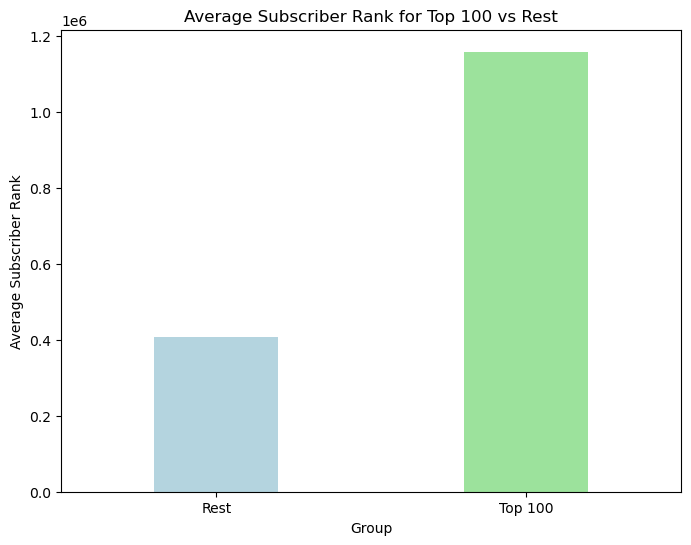

In [ ]:
top_df = agg_df_2[agg_df_2['channel_id'].isin(top_500_nodes)]

# Filter for the rest of the channels
rest_df = agg_df_2[agg_df_2['channel_id'].isin(rest_of_the_nodes)]

std_dev_top_top = top_df['subscribers_cc'].mean()
std_dev_rest_rest = rest_df['subscribers_cc'].mean()

# Add a 'Group' column to each DataFrame
top_df['Group'] = 'Top 100'
rest_df['Group'] = 'Rest'

# Combine the data into one DataFrame
combined_df = pd.concat([top_df, rest_df])

# Calculate the average subscriber rank for each group
combined_df = combined_df.groupby('Group')['subscribers_cc'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Group', y='subscribers_cc', data=combined_df, capsize=0.1, palette=['lightblue','lightgreen'],width=0.4)

plt.title('Average Subscriber Rank for Top 100 vs Rest')
plt.ylabel('Average Subscriber Rank')
plt.xlabel('Group')
plt.savefig('Average_sub.png')

plt.show()

Now, we will proceed to answer the last set of research questions. 

What is happening **before** and **after** collaborations? Is the number of viewers increasing? Can collaborations prolong the life of a channel? 

In [ ]:
# create channel id to channel name mapping set

channel_id_to_name_dict = channel_id_to_name.set_index('channel').T.to_dict('records')[0]


In [ ]:
# The below sample will be used for visualisation purposes of potential trends in the dataset

# prepare collaborators dataset for sampling

collaborators = df_collaborators.dropna()['channel_id']

# take a sample of 10 channels
collaborators_sample = collaborators.sample(9)

# obtain timeseries dataset of the sample of collaborating channels
timeseries_collab_sample = df_timeseries[df_timeseries['channel'].isin(collaborators_sample)]


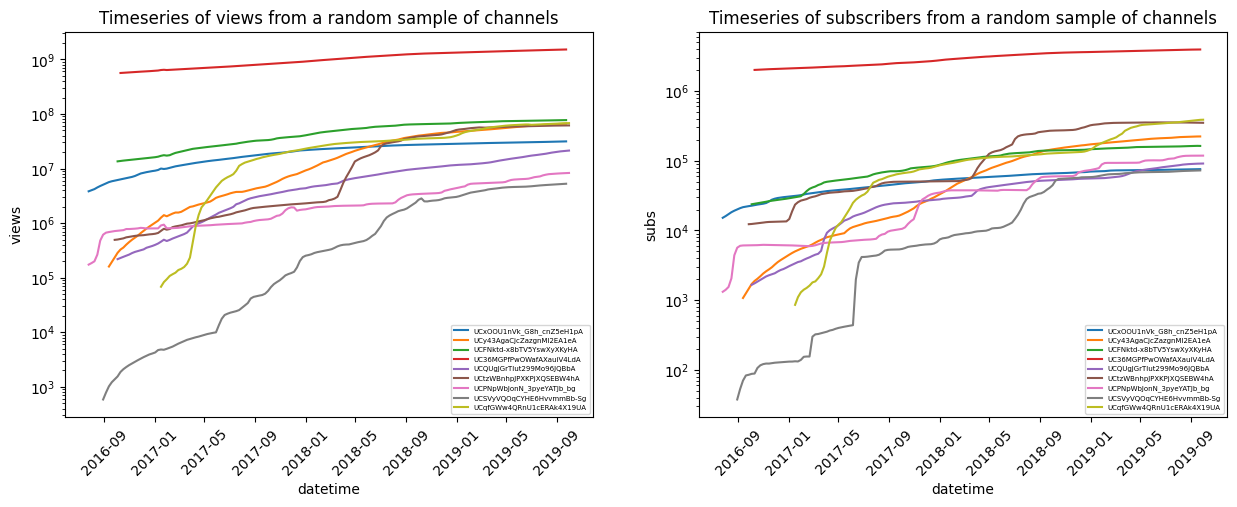

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of number of views a channel has
sns.lineplot(x = 'datetime', y = 'views', hue = 'channel', data = timeseries_collab_sample, ax=ax1)
ax1.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
plt.title("Timeseries of views from a random sample of channels")

ax2 = fig.add_subplot(1, 2, 2)

# plot timeseries of number of subscribers a channel has
sns.lineplot(x = 'datetime', y = 'subs', hue = 'channel', data = timeseries_collab_sample, ax=ax2)
ax2.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
plt.title("Timeseries of subscribers from a random sample of channels")
plt.show()

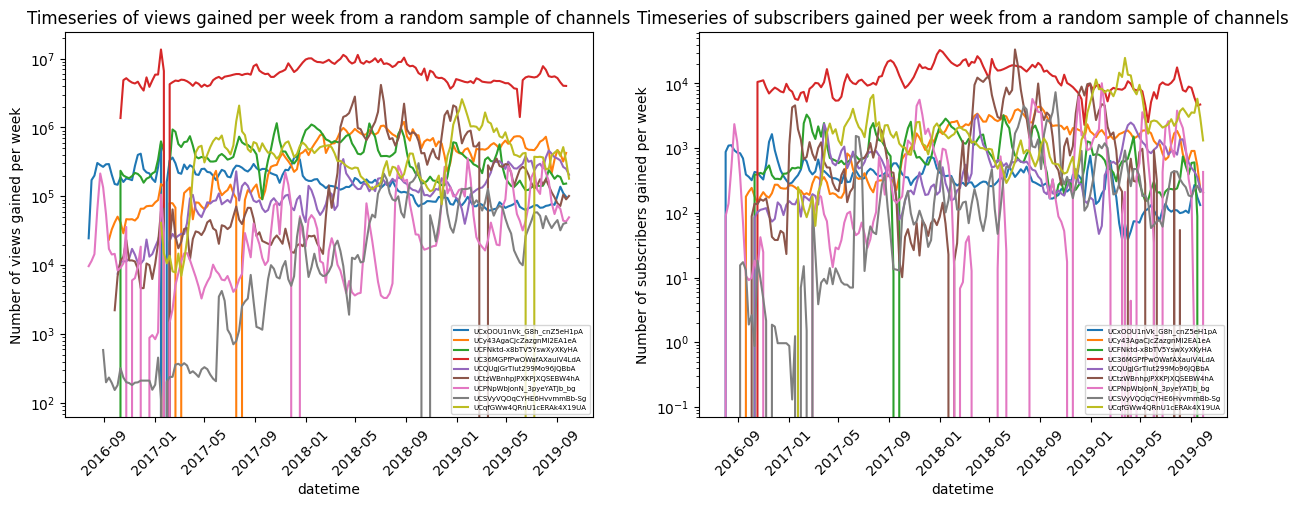

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of changes in number of views a channel has
sns.lineplot(x = 'datetime', y = 'delta_views', hue = 'channel', data = timeseries_collab_sample, ax=ax1)
ax1.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
plt.title("Timeseries of views gained per week from a random sample of channels")
plt.ylabel("Number of views gained per week")

ax2 = fig.add_subplot(1, 2, 2)

# plot timeseries of changes in number of subscribers a channel has
sns.lineplot(x = 'datetime', y = 'delta_subs', hue = 'channel', data = timeseries_collab_sample, ax=ax2)
ax2.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
plt.title("Timeseries of subscribers gained per week from a random sample of channels")
plt.ylabel("Number of subscribers gained per week")
plt.show()

## What is happening **before** and **after** collaborations?

We will first explore the impact of collaborations on a channel's views and subscriptions. 

In [ ]:
# working with sample channels to visualise  trends

# take a sample channel
collab_example = collaborators.sample(1)

# obtain weekly collaboration data of sample channel
channel_collab_example = df_weekly_collaborators[df_weekly_collaborators['channel_id'].isin(collab_example)]

# add binary column for presence of collaborations in a particular week
channel_collab_example['is_collaborating'] = channel_collab_example['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)

# obtain timeseries data of the sample channel
timeseries_collab_example = df_timeseries[df_timeseries['channel'].isin(collab_example)]

/var/folders/1q/2jhpjh7924qd7d3drsy_79xw0000gn/T/ipykernel_5263/3583751445.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_collab_example['is_collaborating'] = channel_collab_example['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)


([], [])

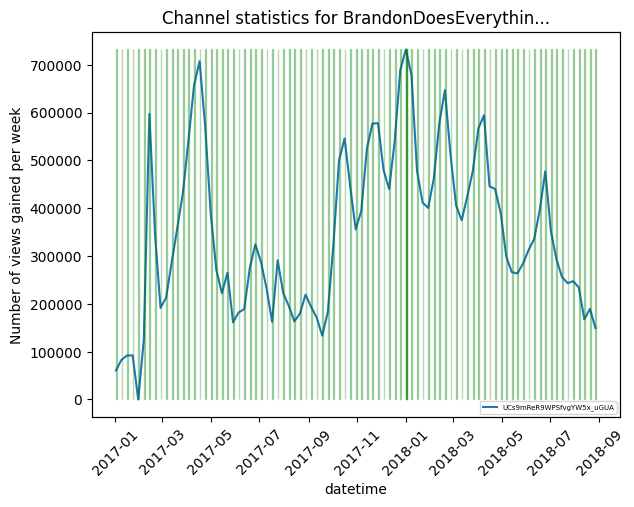

In [ ]:
# plot graph of changes in views of the sample channel with collaboration data

# filter dates in sample data to obtain smaller sample size
sample_start_date = pd.Timestamp('2017-01-01')
sample_end_date = pd.Timestamp('2018-09-01')

dataset = timeseries_collab_example.drop(timeseries_collab_example[timeseries_collab_example.datetime < sample_start_date].index).copy()
dataset.drop(dataset[dataset.datetime > sample_end_date].index, inplace=True)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of changes in number of views a channel has
sns.lineplot(x = 'datetime', y = 'delta_views', hue = 'channel', data = dataset, ax=ax1, color="blue")
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
plt.ylabel("Number of views gained per week")
ax1.set_title("Channel statistics for " + channel_id_to_name_dict.get(collab_example.values[0]))

ax2 = ax1.twinx()

# plot collaboration binary timeline
# plot green for collaboration in the week
s1 = channel_collab_example[channel_collab_example['is_collaborating'] == 1]
data = channel_collab_example.copy()
data['datetime'] = data['Year-Week'].apply(lambda d: datetime.datetime.strptime(d + '-1', '%Y-%W-%w'))
data.drop(data[data.datetime > sample_end_date].index, inplace=True)
data.drop(data[data.datetime < sample_start_date].index, inplace=True)
inxval = matplotlib.dates.date2num(data[data['is_collaborating'] == 1]['datetime'])
times= list(zip(inxval, np.ones(len(s1))))
ax2.broken_barh(times, (0, 100), color="green", alpha = 0.3)
plt.yticks([])

We will take a closer look at popular gaming youtuber PewDiePie's collaboration trends and number of viewers gained per week. 

/var/folders/1q/2jhpjh7924qd7d3drsy_79xw0000gn/T/ipykernel_5263/3532057070.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_collab_example_pewdiepie['is_collaborating'] = channel_collab_example_pewdiepie['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)


([], [])

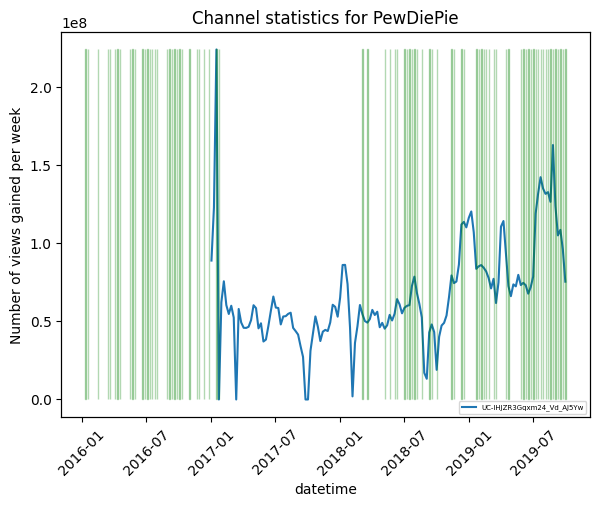

In [ ]:
# plot graph of changes in views of PewDiePie's channel with collaboration data

# obtain weekly collaboration data of PewDiePie
channel_collab_example_pewdiepie = df_weekly_collaborators[df_weekly_collaborators['channel_id'].isin({'UC-lHJZR3Gqxm24_Vd_AJ5Yw'})]

# add binary column for presence of collaborations in a particular week
channel_collab_example_pewdiepie['is_collaborating'] = channel_collab_example_pewdiepie['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)

# obtain timeseries data of PewDiePie
timeseries_collab_example_pewdiepie = df_timeseries[df_timeseries['channel'].isin({'UC-lHJZR3Gqxm24_Vd_AJ5Yw'})]

dataset = timeseries_collab_example_pewdiepie.drop(timeseries_collab_example_pewdiepie[timeseries_collab_example_pewdiepie.datetime < sample_start_date].index).copy()

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)

# plot timeseries of changes in number of views a channel has
sns.lineplot(x = 'datetime', y = 'delta_views', hue = 'channel', data = dataset, ax=ax1, color="blue")
plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize = 5)
plt.ylabel("Number of views gained per week")
ax1.set_title("Channel statistics for " + channel_id_to_name_dict.get('UC-lHJZR3Gqxm24_Vd_AJ5Yw'))

ax2 = ax1.twinx()

# plot collaboration binary timeline
# plot green line for every week in which a collaboration happens
s1 = channel_collab_example_pewdiepie[channel_collab_example_pewdiepie['is_collaborating'] == 1]
data = channel_collab_example_pewdiepie.copy()
data['datetime'] = data['Year-Week'].apply(lambda d: datetime.datetime.strptime(d + '-1', '%Y-%W-%w'))
inxval = matplotlib.dates.date2num(data[data['is_collaborating'] == 1]['datetime'])
times= list(zip(inxval, np.ones(len(s1))))
ax2.broken_barh(times, (0, 100), color="green", alpha = 0.3)
plt.yticks([])

In [ ]:
# obtain weekly collaboration data of sample channel
weekly_collaborators_sample = df_weekly_collaborators[df_weekly_collaborators['channel_id'].isin(collaborators_sample)]

# add binary column for presence of collaborations in a particular week
weekly_collaborators_sample['is_collaborating'] = weekly_collaborators_sample['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)

/var/folders/1q/2jhpjh7924qd7d3drsy_79xw0000gn/T/ipykernel_5263/2401836185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_collaborators_sample['is_collaborating'] = weekly_collaborators_sample['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else 1)


Text(0, 0.6, 'Views gained per week')

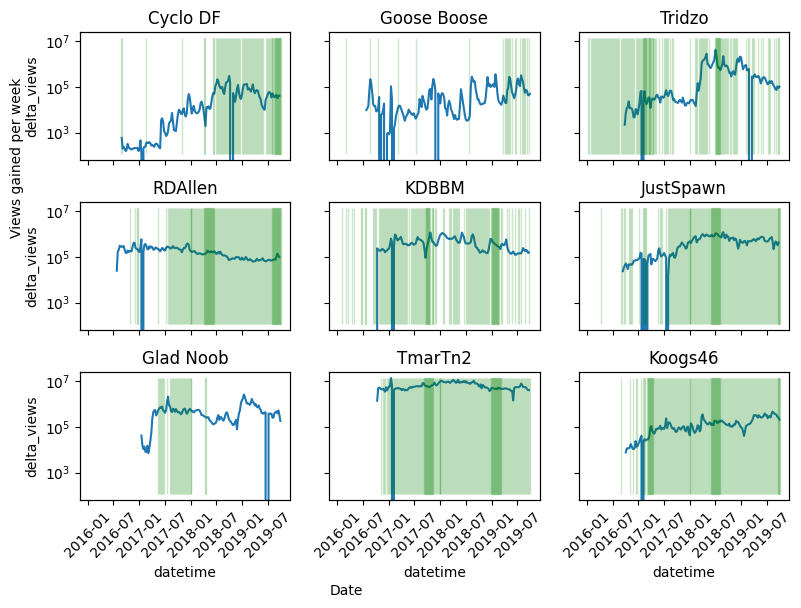

In [ ]:
# plot graph of changes in views of the sample channel with collaboration data

fig, ax = plt.subplots(3,3,figsize= (8,6), sharey = True, sharex = True)

grouped = timeseries_collab_sample.groupby('channel').apply(lambda x: pd.DataFrame({
        'datetime': x['datetime'].values, 
        'delta_views': x['delta_views'].values
    }))

# index channels for easy iteration 
indexed_channels = list(set(grouped.index.get_level_values(0).values))

# plot 9 graphs of changes in views of the 9 sample channels with collaboration data
for i in range(9):

    sbplt = ax[i%3, math.floor(i/3)]

    # plot timeseries of changes in number of views a channel has
    sns.lineplot(x = 'datetime', y = 'delta_views', data = grouped.loc[indexed_channels[i]], ax=sbplt)
    sbplt.set_yscale('log')
    sbplt.set_title(channel_id_to_name_dict.get(indexed_channels[i]))
    sbplt.tick_params(axis='x', labelrotation=45)

    sbplt2 = sbplt.twinx()

    # plot collaboration binary timeline
    # plot green for collaboration in the week
    s1 = weekly_collaborators_sample[ (weekly_collaborators_sample['is_collaborating'] == 1) & (weekly_collaborators_sample['channel_id'] == indexed_channels[i])]
    inxval = matplotlib.dates.date2num(weekly_collaborators_sample[(weekly_collaborators_sample['is_collaborating'] == 1) & (weekly_collaborators_sample['channel_id'] == indexed_channels[i])]['Year-Week'].apply(lambda d: datetime.datetime.strptime(d + '-1', '%Y-%W-%w')))
    times= list(zip(inxval, np.ones(len(s1))))
    plt.yticks([])
    sbplt2.broken_barh(times, (0, 100), color="green", alpha = 0.2)
    
fig.tight_layout()

fig.text(0.4,0, "Date")
fig.text(0,0.6, "Views gained per week", rotation = 90)


Below, we plot both the views obtained by a random sample of 10 samples from the 100 most influential channels as found in the previous part with the times the channel engaged in collaborations with other channels. 

Text(0, 0, 'Views gained per week of a sample of 10 channels among the 100 most influential channels')

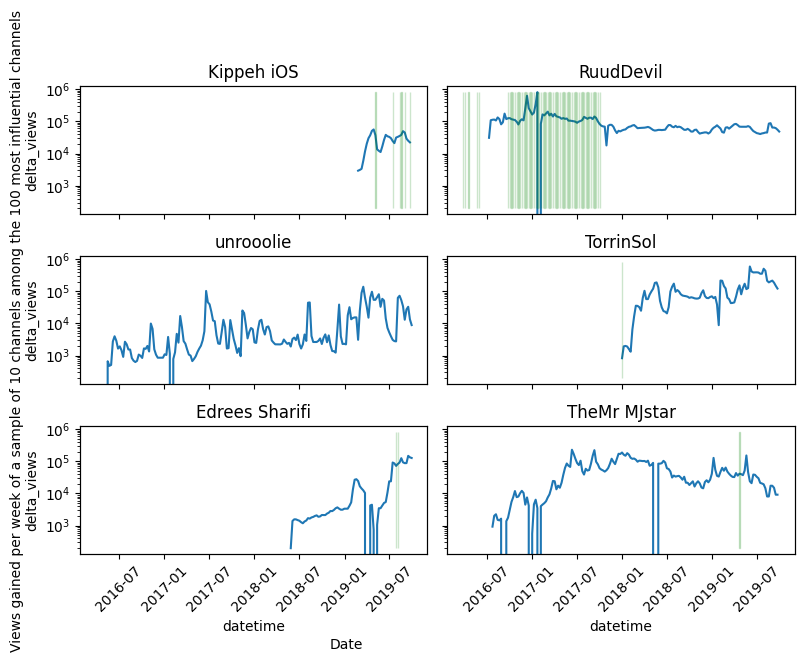

In [ ]:
# plot graph of changes in views of the sample of 10 from the 100 most influenctial channels with collaboration data

fig, ax = plt.subplots(3,2,figsize= (8,6), sharey = True, sharex = True)

# plot 6 graphs for the channels with existing stats in the given datasets
for i in range(6):

    sbplt = ax[i%3, math.floor(i/3)]

    # plot timeseries of changes in number of views a channel has
    sns.lineplot(x = 'datetime', y = 'delta_views', data = most_influential_grouped.loc[indexed_influential_channels[i]], ax=sbplt)
    sbplt.set_yscale('log')
    sbplt.set_title(channel_id_to_name_dict.get(indexed_influential_channels[i]))
    sbplt.tick_params(axis='x', labelrotation=45)

    sbplt2 = sbplt.twinx()

    # plot collaboration binary timeline
    # plot green for collaboration in the week
    s1 = weekly_collab_most_influential[ (weekly_collab_most_influential['is_collaborating'] == 1) & (weekly_collab_most_influential['channel_id'] == indexed_influential_channels[i])]
    inxval = matplotlib.dates.date2num(weekly_collab_most_influential[(weekly_collab_most_influential['is_collaborating'] == 1) & (weekly_collab_most_influential['channel_id'] == indexed_influential_channels[i])]['Year-Week'].apply(lambda d: datetime.datetime.strptime(d + '-1', '%Y-%W-%w')))
    times= list(zip(inxval, np.ones(len(s1))))
    plt.yticks([])
    sbplt2.broken_barh(times, (0, 100), color="green", alpha = 0.2)
    
fig.tight_layout()

fig.text(0.4,0, "Date")
fig.text(0,0, "Views gained per week of a sample of 10 channels among the 100 most influential channels", rotation = 90)


Next, we will compute the lifespan of the channels. We define a channel's death to be when the number of new views obtained in a month is less than 20% of the number of subscribers to the channel. 

In [ ]:
# get lifespan of channels, a channel is considred dead if the views it gets in a month is 
# less than 20% of its number of subscribers. 

# find the number of months elapsed between d1 and d2, d2 being the later date
def diff_month(d1, d2): # d2 is always larger than d1
    d1 = datetime.datetime.strptime(d1, "%Y-%m")
    d2 = datetime.datetime.strptime(d2, "%Y-%m")
    d1_month = d1.month
    d2_month = d2.month
    diff_year = abs(d2.year - d1.year)
    return diff_year * 12 + (d2_month - d1_month)

# compute number of months that a channel is considered "alive" according to definition of a "dead" channel
def find_lifespan(grp):
    start_month = min(grp.index.get_level_values(1))
    end_month = min(grp[grp.delta_views < 0.2 * grp.subs].index.get_level_values(1)) if not grp[grp.delta_views < 0.2 * grp.subs].index.get_level_values(1).empty else max(grp.index.get_level_values(1))
    lifespan = diff_month(start_month, end_month)
    # lifespans.append(lifespan)
    return lifespan


In [ ]:
# preprocessing timeseries dataset to extract channel view gain in a month in order to find channel lifespan

df_timeseries['year_month'] = df_timeseries['datetime'].dt.strftime('%Y-%m')

channel_group = df_timeseries.dropna().groupby(['channel','year_month']).agg({'delta_views': "sum", 'subs': "max", 'views': "max", 'datetime': "max"})

channel_group = channel_group.dropna().drop(channel_group[channel_group.subs == 0].index).drop(channel_group[channel_group.views == 0].index).sort_values('datetime', ascending=True)

channel_indexes = list(set(channel_group.index.get_level_values(0).values))


In [ ]:
# create dataset containing each channel and their respective lifespans

channel_lifespan = channel_group.groupby('channel').apply(lambda grp: find_lifespan(grp))

Text(0, 0.5, 'Number of channels')

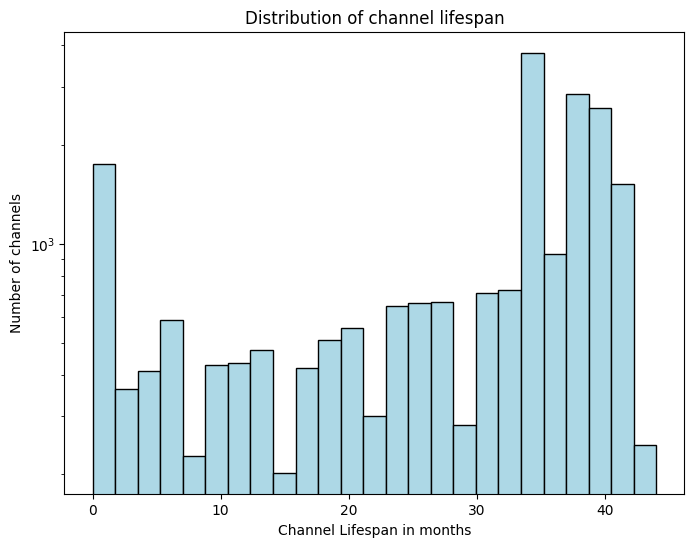

In [ ]:
# plot distribution of lifespan among channels

fig, ax = plt.subplots(figsize = (8,6))

sbplt = ax
sbplt.hist(channel_lifespan, bins = 25, color="lightblue", edgecolor='black')
ax.set_yscale('log')
sbplt.set_title("Distribution of channel lifespan")
plt.xlabel("Channel Lifespan in months")
plt.ylabel("Number of channels")

In [ ]:
# correlation between whether a channel has collaborated and its lifespan

def count_collabs(series): 
    count = 0
    for x in series: 
        count += 0 if x is None else 1
    return count

df_weekly_collaborators['no_of_collabs'] = df_weekly_collaborators['collaborators_in_week'].apply(lambda x: 0 if x is None or pd.isna(x) else count_collabs(x))
df_grouped_collab = df_weekly_collaborators.groupby('channel_id', as_index=False).agg({ 'no_of_collabs' : "sum"})

# merge a table of channels and its corresponding lifespan with table of channels and collab
df_collaborators_lifespan = df_grouped_collab.merge(pd.DataFrame(data={"lifespan": channel_lifespan.values, "channel_id": channel_lifespan.index}), how='inner', on='channel_id').dropna(subset='no_of_collabs')

df_w_collab = df_collaborators_lifespan.merge(df_channels.rename(columns={'channel' : 'channel_id'}), how='inner', on='channel_id').reset_index(drop=True)

df_w_collab_gaming = df_w_collab[df_w_collab['category_cc']=='Gaming']

Next, we will run some regressional analysis on the dataset. 

We will mainly explore the following relationships: 
1. the correlation between the lifespan of a channel and the number of collaborations it engages in
2. the correlation between the number of subscribers a channel has and the number of collaborations it engages in

In [ ]:
# correlation between whether a channel has collaborated and its lifespan

mod_lifespan_collab = smf.ols(formula='lifespan ~ no_of_collabs', data=df_w_collab_gaming)
res_lifespan_collab = mod_lifespan_collab.fit()

print(res_lifespan_collab.summary())

                            OLS Regression Results                            
Dep. Variable:               lifespan   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     110.1
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           1.06e-25
Time:                        19:59:19   Log-Likelihood:                -78583.
No. Observations:               19629   AIC:                         1.572e+05
Df Residuals:                   19627   BIC:                         1.572e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        27.4335      0.097    282.004

A possible reason why the lifespan of a channel may increase with collaboration may be is because of a third confounding factor: the number of videos uploaded. 

We will thus model the lifespan of a channel with the number of videos uploaded as an interactive predictor. 

In [ ]:
# correlation between lifespan and number of collaborations a channel has, taking into account the possible confounding variable of videos uploaded by the channel

mod_lifespan_collab_vid = smf.ols(formula='lifespan ~ no_of_collabs * videos_cc', data=df_w_collab_gaming)
res_lifespan_collab_vid = mod_lifespan_collab_vid.fit()

print(res_lifespan_collab_vid.summary())

                            OLS Regression Results                            
Dep. Variable:               lifespan   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     229.6
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          2.01e-146
Time:                        19:59:19   Log-Likelihood:                -78300.
No. Observations:               19629   AIC:                         1.566e+05
Df Residuals:                   19625   BIC:                         1.566e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Next we will model the relationship between number of collaboration and numebr of subscribers of channels. 

In [ ]:
# collaboration between the number of subscribers a channel has and the number of collaborations the channel engages in

mod_lifespan_collab_vid = smf.ols(formula='subscribers_cc ~ no_of_collabs', data=df_w_collab_gaming)
res_lifespan_collab_vid = mod_lifespan_collab_vid.fit()

print(res_lifespan_collab_vid.summary())

                            OLS Regression Results                            
Dep. Variable:         subscribers_cc   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     162.9
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           3.69e-37
Time:                        19:59:19   Log-Likelihood:            -3.0017e+05
No. Observations:               19629   AIC:                         6.003e+05
Df Residuals:                   19627   BIC:                         6.004e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.806e+05   7775.263     23.223